In [1]:
from figure_utilities import *
from sklearn.linear_model import LinearRegression

### Map of ref and alt counts

In [2]:
heterozygosity_map('chr1')

In [34]:
ref, alt = read_data('./Data/glioblastoma_BT_S2/ref.csv', './Data/glioblastoma_BT_S2/alt.csv', 'chr1')
    
chr1_coverage = ref + alt 

fig = plt.figure(figsize=(12,8), dpi = 300)
plt.imshow(chr1_coverage, norm = 'linear', cmap = 'binary', vmin = 0, vmax = 1) 
#plt.title('map of zero coverage in chromosome 1')
plt.xlabel('locus')
plt.ylabel('cell')
#plt.colorbar(shrink=0.75, location = 'left')
plt.tight_layout()
#fig.subplots_adjust(left=-0.1)
plt.savefig('./figures/chr1_coverage.png')
plt.close()

### Shannon information test

In [7]:
from matplotlib import cm
from utilities import shannon_info

step = 10
tests = np.arange(step, 200 + step, step=step)
proportions = np.linspace(0, 1, num=50)
X, Y = np.meshgrid(proportions, tests)

info_content = np.empty((len(tests), len(proportions)))
for i in range(len(tests)):
    for j in range(len(proportions)):
        if tests[i] * proportions[j] < 1:
            info_content[i,j] = 0
        else:
            info_content[i,j] = shannon_info(tests[i], tests[i] * proportions[j])

fig, ax = plt.subplots(figsize=(5,5), dpi = 300, subplot_kw={"projection": "3d"})

fig.set_facecolor('white')
surf = ax.plot_surface(X, Y, info_content, linewidth=1, cmap = cm.coolwarm)
#ax.set_zlim(0, 7)
ax.set_xlabel('proportion of cells affected', fontsize = 11)
ax.set_ylabel('total number of cells', fontsize = 11)
ax.set_zlabel('information content (nat)', fontsize = 11)
#fig.colorbar(surf, shrink=0.5, aspect=5, location = 'left')
fig.tight_layout()
fig.subplots_adjust(left=-0.1)
fig.savefig('./figures/shannon_info.png')
plt.close(fig)

### Mutation detection test

In [22]:
datadir = [
        './test_results/mut_detection_25c_tp2_def/', 
        './test_results/mut_detection_400c_tp2_def/', 
        './test_results/mut_detection_25c_tp2_oth/', 
        './test_results/mut_detection_400c_tp2_oth/'
]

fig, axes = plt.subplots(4, 3, figsize = (13,15), dpi = 300)

for i in range(4):
    sorted_posteriors = np.load(datadir[i] + 'sortedP.npy')
    tpr = np.load(datadir[i] + 'TPR.npy')
    fpr = np.load(datadir[i] + 'FPR.npy')
    tpr_alt = np.load(datadir[i] + 'altTPR.npy')
    fpr_alt = np.load(datadir[i] + 'altFPR.npy')
    make_roc_curve(axes[i,:], sorted_posteriors, tpr, fpr, tpr_alt, fpr_alt)

row_names = [
    '25 cells\n Poisson coverage', 
    '400 cells\n Poisson coverage', 
    '25 cells\n data coverage', 
    '400 cells\n data coverage'
]
for ax, rn in zip(axes[:,0], row_names): 
    ax.annotate(rn, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
        xycoords=ax.yaxis.label, textcoords='offset points',
        size='large', ha='right', va='center', color = 'red')

fig.tight_layout()
fig.savefig('./figures/mut_detection_tp2.png')
plt.close(fig)

### Threshold test

In [23]:
data = np.empty((3,2), dtype = np.ndarray)
path = './test_results/thresholds_50c_200m_200f/'
dist_rev = np.load(path + 'dist_rev.npy')
dist_irr = np.load(path + 'dist_irr.npy')
n_selected = np.load(path + 'n_selected.npy')
runtime_rev = np.load(path + 'runtime_rev.npy')
runtime_irr = np.load(path + 'runtime_irr.npy')

dist = mix_columns(dist_rev, dist_irr)
runtime = mix_columns(runtime_rev, runtime_irr)

fig, axes = plt.subplots(3, 1, figsize = (6,9), dpi = 300)
thresholds = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
ylabels = [
    'MSE of distance matrix', 
    'number of selected loci', 
    'runtime (s)'
]
colors = ['pink', 'lightblue'] * 7
positions = np.array([1/8, -1/8] * 7) + np.arange(1, 14+1)

bp1 = make_boxplot(axes[0], dist, colors = colors, positions = positions)
bp2 = make_boxplot(axes[1], n_selected, colors = 'orchid', positions = np.arange(1,8) * 2 - 0.5)
bp3 = make_boxplot(axes[2], runtime, colors = colors, positions = positions)

for i in range(3):
    axes[i].set_ylabel(ylabels[i])
    axes[i].set_xticks(np.arange(1,8) * 2 - 0.5, labels = thresholds)
axes[0].set_ylim(5, 60)
axes[0].legend([bp1['boxes'][0], bp1['boxes'][1]], ['reversible', 'irreversible'])
axes[2].set_xlabel('threshold')
axes[2].set_yscale('log')
axes[2].legend([bp1['boxes'][0], bp1['boxes'][1]], ['reversible', 'irreversible'])

fig.align_ylabels(axes)
fig.tight_layout()
fig.savefig('./figures/thresholds.png')
plt.close(fig)

### Sensitivity test

In [47]:
data = np.load('./test_results/number_affected_50c/RH.npy')

fig, ax = plt.subplots(figsize = (4,4), dpi = 300)
ax.set_facecolor('lightgray')
ax.bar(np.arange(2,50), data[:,0], alpha = 0.75, label = 'mutation')
ax.bar(np.arange(2,50), data[:,1], alpha = 0.75, label = 'correct genotypes')
ax.bar(np.arange(2,50), data[:,2], alpha = 0.75, label = 'correct direction')
ax.set_xlabel('number of affected cells')
ax.set_ylabel('sensitivity')
ax.legend(loc = 'lower right')
ax.grid(True, c = 'white')
ax.set_axisbelow(True)
fig.tight_layout()
fig.savefig('./figures/sensitivity.png')
plt.close(fig)

### Results of space swap test

In [3]:
dirs = [
        './test_results/spaceswap_50c_100m_100f/', 
        './test_results/spaceswap_50c_200m_200f/', 
        './test_results/spaceswap_50c_400m_400f/'
]
fnames = ['likelihoods.npy', 'dist.npy', 'runtime.npy']
data = np.empty((3,3), dtype = np.ndarray)
for i in range(3):
    for j in range(3):
        data[i,j] = np.load(dirs[j] + fnames[i])

fig, axes = plt.subplots(3, 3, sharex = 'row', sharey = 'row', figsize = (12,13), dpi = 300)
titles = [
    '50 cells\n 100 true mutations\n 100 fake mutations',
    '50 cells\n 200 true mutations\n 200 fake mutations',
    '50 cells\n 400 true mutations\n 400 fake mutations'
]
xlabels = ['C', 'M', 'CM', 'MC']
ylabels = [
    'mean loglikelihood \n compared to real tree', 
    'MSE of distance matrix', 
    'runtime (s)'
]
colors = ['skyblue', 'gold', 'green', 'limegreen']
for i in range(3): 
    axes[i,0].set_ylabel(ylabels[i])
    for j in range(3): 
        make_boxplot(axes[i,j], data[i,j], colors = colors)
        axes[i,j].set_title(titles[j])
        axes[i,j].set_xticks(np.arange(1,5), labels = xlabels)

for j in range(3): 
    axes[0,j].set_title(titles[j])
    #axes[-1,j].set_yscale('log') 
    axes[-1,j].set_xticks(np.arange(1,5), labels = xlabels)

fig.align_ylabels(axes)
fig.tight_layout()
fig.savefig('./figures/space_swap(presentation).png')
plt.close(fig)

In [7]:
fig, axes = plt.subplots(4, 3, figsize = (12,15), sharex = True, sharey = True, dpi = 300)
for i in range(4):
    axes[i,0].set_ylabel('MSE of distance matrix')
    for j in range(3):
        dist_vs_likelihood(axes[i,j], data[0,j][:,i], data[1,j][:,i], colors[i])

for j in range(3):
    axes[3,j].set_xlabel('mean loglikelihood \n compared to real tree')
    axes[0,j].set_title(titles[j])

row_names = ['C', 'M', 'CM', 'MC']
for ax, rn in zip(axes[:,0], row_names): 
    ax.annotate(rn, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
        xycoords=ax.yaxis.label, textcoords='offset points',
        size='large', ha='right', va='center', color = 'red')

fig.tight_layout()
fig.savefig('./figures/dist_vs_likelihood.png')
plt.close(fig)

### Reversibility test

In [14]:
path = './test_results/reversibility_50c_100m/'
likelihoods_rev = np.load(path + 'likelihoods_rev.npy')
likelihoods_irr = np.load(path + 'likelihoods_irr.npy')
dist_rev = np.load(path + 'dist_rev.npy')
dist_irr = np.load(path + 'dist_irr.npy')

likelihoods = mix_columns(likelihoods_rev, likelihoods_irr)
dist = mix_columns(dist_rev, dist_irr)

fig, axes = plt.subplots(2, 1, figsize = (4.5,7), dpi = 300)
wrong_prop = [0.0, 0.25, 0.5, 0.75, 1.0]
ylabels = [
    'mean loglikelihood\n compared to real tree', 
    'MSE of distance matrix'
]
colors = ['pink', 'lightblue'] * 5
positions = np.array([1/8, -1/8] * 5) + np.arange(1, 10+1)

bp1 = make_boxplot(axes[0], likelihoods, colors = colors, positions = positions)
bp2 = make_boxplot(axes[1], dist, colors = colors, positions = positions)

for i in range(2):
    axes[i].set_ylabel(ylabels[i])
    axes[i].set_xticks(np.arange(1,6) * 2 - 0.5, labels = wrong_prop)
axes[1].set_xlabel('proportion of wrong directions')
axes[0].legend([bp1['boxes'][0], bp1['boxes'][1]], ['reversible', 'irreversible'])
axes[1].legend([bp2['boxes'][0], bp2['boxes'][1]], ['reversible', 'irreversible'])

fig.align_ylabels(axes)
fig.tight_layout()
fig.savefig('./figures/reversibility.png')
plt.close(fig)

### Distance between random trees

In [ ]:
data = np.load('./test_results/random_dist.npy')
fig, ax = plt.subplots(figsize = (3,4), dpi = 300)
make_boxplot(ax, data)
#ax.set_title('distance between ramdom trees')
ax.set_xlabel('tree size (number of cells)')
ax.set_ylabel('MSE of distance matrix')
ax.set_xticklabels([25, 50, 100, 200])
fig.tight_layout()
fig.savefig('./figures/random_dist.png')
plt.close(fig)

### Distribution of data coverage

In [2]:
fig, ax = plt.subplots(figsize = (12,6), dpi = 300)
ref, alt = read_data('./Data/glioblastoma_BT_S2/ref.csv', './Data/glioblastoma_BT_S2/alt.csv')
coverages = ref.flatten() + alt.flatten()
coverage_hist(ax, coverages)
fig.tight_layout()
fig.savefig('./figures/coverage_hist.png')
plt.close(fig)

### Real data

In [11]:
history = np.load('./test_results/real_data/history.npy')
fig, ax = plt.subplots(figsize=(4,3), dpi=300)
ax.set_facecolor('lightgray')
ax.plot(history)
ax.set_xlabel('move count')
ax.set_ylabel('log-likelihood')
ax.grid(True, c='white')
fig.tight_layout()
fig.savefig('./figures/history.png')
plt.close(fig)

In [4]:
ref_raw, alt_raw = read_data('./Data/glioblastoma_BT_S2/ref.csv', './Data/glioblastoma_BT_S2/alt.csv')
n_select = 1000
posteriors = np.load('./test_results/real_data/posteriors.npy')
sorted_posteriors = np.sort(np.sum(posteriors[:,3:], axis = 1))
sorted_posteriors = np.flip(sorted_posteriors)

fig, ax = plt.subplots(figsize=(4,3), dpi=300)
ax.set_facecolor('lightgray')
ax.plot(sorted_posteriors)
ax.set_xlabel('rank')
ax.set_ylabel('posterior')
ax.grid(True, c='white')
fig.tight_layout()
fig.savefig('./figures/sorted_posteriors.png')
plt.close(fig)

In [65]:
tissue

array(['Tumor', 'Tumor', 'Tumor', ..., 'Periphery', 'Periphery',
       'Periphery'], dtype='<U9')

/usr/local/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


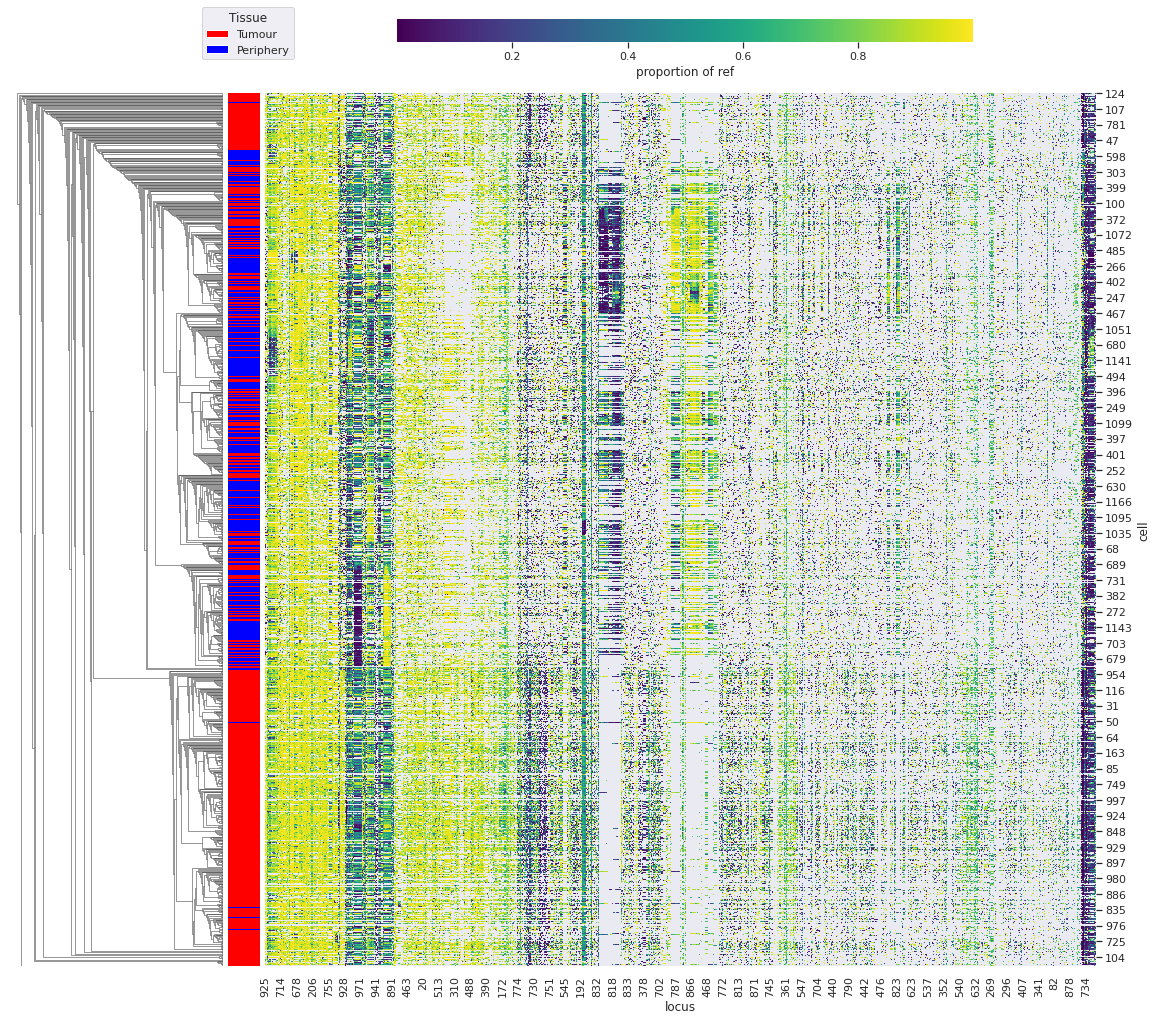

In [112]:
from tree import CellTree
import seaborn as sns
from matplotlib.patches import Patch

sns.set(rc={'savefig.dpi':300})

ref_raw, alt_raw = read_data('./Data/glioblastoma_BT_S2/ref.csv', './Data/glioblastoma_BT_S2/alt.csv')
n_select = 1000
posteriors = np.load('./test_results/real_data/posteriors.npy')
order = np.argsort(np.sum(posteriors[:,3:], axis = 1))
selected = order[-1000:]
ref, alt = ref_raw[:,selected], alt_raw[:,selected]

ref_proportion = (ref+1) / (ref + alt + 2)
mask = (ref + alt == 0)
#alpha = 2 * np.arctan(ref + alt) / np.pi 

parent_vec = np.load('./test_results/real_data/ct_parent_vec.npy')
ct = CellTree(len(parent_vec)//2 + 1)
ct.parent_vec = parent_vec
Z = ct.linkage_matrix

tissue = pd.read_csv('./Data/glioblastoma_BT_S2/metadata.csv')['TISSUE'].to_numpy(dtype=str)
lut = dict(zip(set(tissue), ['red', 'blue']))
colors = [lut[t] for t in tissue]

handles = [Patch(facecolor=lut[name]) for name in lut]

heatmap = sns.clustermap(ref_proportion, figsize=(16,16), row_linkage=Z, row_colors=colors, cmap='viridis', mask = mask, cbar_pos=(0.35,0.84,0.5,0.02),cbar_kws={'orientation':'horizontal'})
heatmap.ax_cbar.set_xlabel('proportion of ref') # label for the colour bar
heatmap.ax_col_dendrogram.set_visible(False) # don't show the column dendrogram
heatmap.ax_heatmap.set_xlabel('locus')
heatmap.ax_heatmap.set_ylabel('cell')
plt.legend(handles, ['Tumour', 'Periphery'], title='Tissue', loc=[-0.34,-0.75]) # custom legend for row colours
heatmap.savefig('./figures/heatmap.png')

In [5]:
from tree import CellTree
import graphviz

parent_vec = np.load('./test_results/real_data/ct_parent_vec.npy')
ct = CellTree(len(parent_vec)//2 + 1)
ct.parent_vec = parent_vec

tissue = pd.read_csv('./Data/glioblastoma_BT_S2/metadata.csv')['TISSUE'].to_numpy(dtype=str)
colors = ['red' if t == 'Tumor' else 'blue' for t in tissue]

g = graphviz.Graph(filename='tree.svg', engine='neato')
for node in ct.nodes:
    if node.isleaf:
        g.node(str(node.ID), label='', shape='circle', style='filled', color=colors[node.ID])
    else:
        g.node(str(node.ID), label='', shape='point', style='filled', color='gray')
    
    if not node.isroot:
        g.edge(str(node.parent.ID), str(node.ID))

g.save('./figures/ct_graphviz.txt')

'./figures/ct_graphviz.txt'